In [1]:
!rm stan_utility.py

!wget https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py

--2019-07-23 09:18:03--  https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5593 (5.5K) [text/plain]
Saving to: ‘stan_utility.py’

stan_utility.py     100%[===================>]   5.46K  --.-KB/s    in 0s      

2019-07-23 09:18:03 (12.2 MB/s) - ‘stan_utility.py’ saved [5593/5593]



In [2]:
%matplotlib inline

import random
random.seed(123)

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import importlib

In [3]:
import pystan
import stan_utility

import survivalstan

### SurvivalStan - Exponential Model

Tutorial:
http://www.hammerlab.org/2017/06/26/introducing-survivalstan/

S(t) = exp( -a*t )

In [4]:
# Simulate data
# Model: exp(-3*t) * exp(0.5*sex)
df2 = survivalstan.sim.sim_data_exp_correlated(
    N=500, censor_time=20, rate_form='1 + sex', rate_coefs=[-3, 0.5])

df2.head()

,sex,age,rate,true_t,t,event,index
0,male,56,0.082085,12.564127,12.564127,True,0
1,male,58,0.082085,12.626269,12.626269,True,1
2,male,49,0.082085,13.113105,13.113105,True,2
3,male,53,0.082085,70.941144,20.000000,False,3
4,female,54,0.049787,45.769516,20.000000,False,4


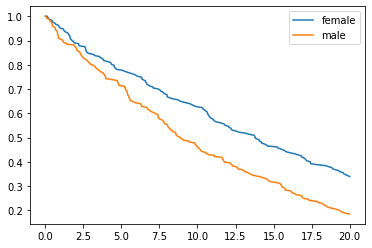

In [5]:
survivalstan.utils.plot_observed_survival(
    df2.query('sex == "female"'),
    time_col='t',
    event_col='event',
    label='female')
survivalstan.utils.plot_observed_survival(
    df2.query('sex == "male"'),
    time_col='t',
    event_col='event',
    label='male')
plt.legend()

In [ ]:
# Model used
# print(survivalstan.models.exp_survival_model)
Niter = 2000
Nchains = 2
max_treedepth = 20

fit1 = survivalstan.fit_stan_survival_model(
    df=df2,
    time_col='t',
    event_col='event',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ age + sex',
    model_cohort = 'exp model',
    iter = Niter,
    chains = Nchains,
    stan_data = {'max_treedepth': max_treedepth,
                 'adapt_delta': 0.99,
                 'warmup': 1000},
    seed = 123
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0176fed484efbd961d78e8973c25ff98 NOW.


NOT reusing model.


In [19]:
# Diagnostics - tutorial
survivalstan.utils.filter_stan_summary([fit1], pars=['lp__','beta'])

,mean,se_mean,sd,2.5%,50%,97.5%,Rhat
lp__,-1357.905960,0.227870,2.378224,-1363.472717,-1357.473731,-1354.351369,1.057248
beta[1],0.482973,0.005966,0.106305,0.280151,0.481027,0.697667,1.018557
beta[2],-0.004760,0.001005,0.007604,-0.019251,-0.005029,0.009420,1.086090


In [21]:
# Diagnostics
# http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html

sfit1 = fit1['fit']
stan_utility.check_all_diagnostics(sfit1)

n_eff / iter looks reasonable for all parameters
Rhat for parameter tau_raw[2] is 1.1721425116037232!
Rhat for parameter log_lik[149] is 1.1000333944915106!
  Rhat above 1.1 indicates that the chains very likely have not mixed
2101.0 of 10000 iterations ended with a divergence (21.01%)
  Try running with larger adapt_delta to remove the divergences
0 of 10000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


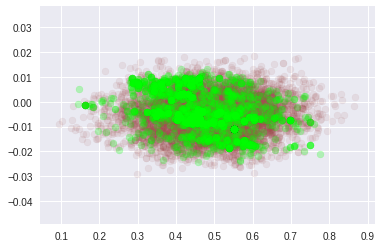

In [22]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility.partition_div(sfit1)

plt.scatter([x[0] for x in nondiv_params['beta']], [x[1] for x in nondiv_params['beta']], 
             color = mid_highlight, alpha=0.1)

plt.scatter([x[0] for x in div_params['beta']], [x[1] for x in div_params['beta']], 
             color = green, alpha=0.25)